In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

In [1]:
import pandas as pd
df=pd.read_csv("C:\\Users\\srrml\\Desktop\\ML assignments\\Lab04-srishti7103\\data-preprocessing-and-regression-with-scikit-learn-srishti7103\\kc_house_data.csv")


In [3]:
np.random.seed(42)
df.loc[df.sample(frac=0.05).index, 'sqft_lot'] = np.nan

np.random.seed(43)
df.loc[df.sample(frac=0.05).index, 'bathrooms'] = np.nan


 # Task 2: Advanced EDA & Feature Engineering

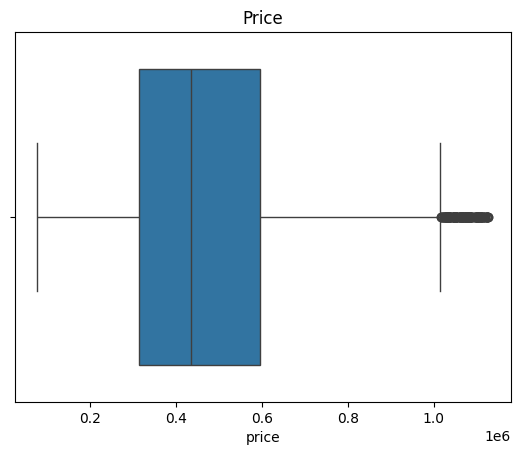

In [4]:
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return df_filtered

df = remove_outliers(df, 'price')
df = remove_outliers(df, 'sqft_living')
df = remove_outliers(df, 'bedrooms')

sns.boxplot(x=df['price'])
plt.title('Price')

plt.show()

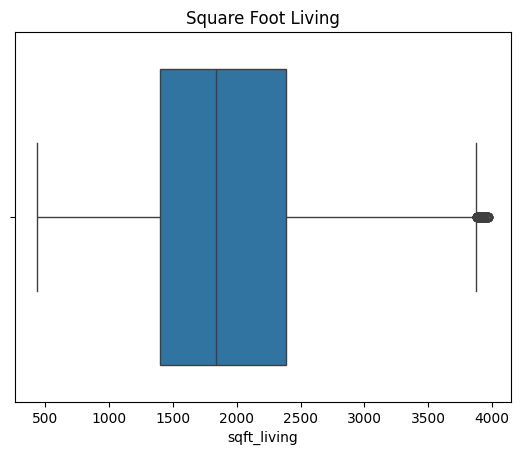

In [5]:
sns.boxplot(x=df['sqft_living'])
plt.title('Square Foot Living')

plt.show()

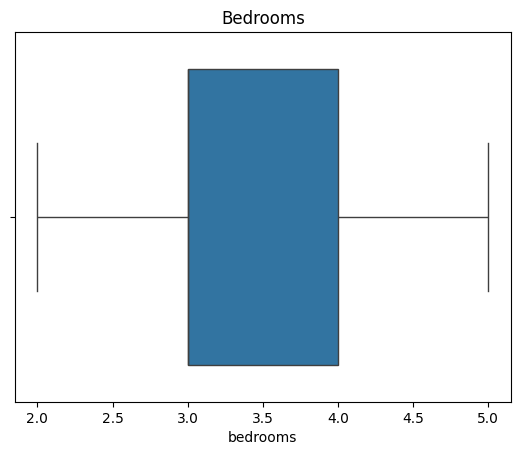

In [6]:
sns.boxplot(x=df['bedrooms'])
plt.title('Bedrooms')

plt.show()

In [7]:
df['date'] = pd.to_datetime(df['date'])
df['sale_year'] = df['date'].dt.year
df['sale_month'] = df['date'].dt.month
df['house_age'] = df['sale_year'] - df['yr_built']

In [8]:
df['was_renovated'] = (df['yr_renovated'] != 0).astype(int)
df['age_since_renovation'] = df['house_age'] - (df['sale_year'] - df['yr_renovated'])
df['age_since_renovation'] = df['age_since_renovation'].clip(lower=0)

In [9]:
df['sqft_living_per_floor'] = df['sqft_living'] / df['floors'].replace(0, np.nan)
df['bath_per_bed'] = df['bathrooms'] / df['bedrooms'].replace(0, np.nan)

# Task 2: Preprocessing Pipeline

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
numerical_features = ['sqft_living', 'house_age', 'sqft_lot', 'bathrooms', 'bedrooms', 'sqft_living_per_floor', 'bath_per_bed', 'age_since_renovation']
categorical_features = ['zipcode']
passthrough_features = ['grade', 'condition', 'was_renovated']
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),    
    ('scaler', StandardScaler())            
])
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))      
])
passthrough_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))  
])
preprocessor = ColumnTransformer(transformers=[
    ('numeric', numerical_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features),
    ('passthrough', passthrough_pipeline, passthrough_features)
])
X = df.drop(columns=['price', 'id', 'date', 'yr_built', 'yr_renovated'])
y = df['price']
X_processed = preprocessor.fit_transform(X)
print(X_processed)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 217274 stored elements and shape (19687, 81)>
  Coords	Values
  (0, 0)	-1.077011615321932
  (0, 1)	0.5354467185997986
  (0, 2)	-0.2248551667027389
  (0, 3)	-1.5620749160988092
  (0, 4)	-0.38153539608425463
  (0, 5)	-0.41855959427815337
  (0, 6)	-1.5038601086681824
  (0, 7)	-0.17882038272300677
  (0, 74)	1.0
  (0, 78)	7.0
  (0, 79)	3.0
  (1, 0)	0.9022728609882553
  (1, 1)	0.6732361530234896
  (1, 2)	-0.17962675671776712
  (1, 3)	-0.04449746451598427
  (1, 4)	-0.38153539608425463
  (1, 5)	-0.23593067440452367
  (1, 6)	-0.01067266745708137
  (1, 7)	3.2563386684982594
  (1, 63)	1.0
  (1, 78)	7.0
  (1, 79)	3.0
  (1, 80)	1.0
  (2, 0)	-1.6608293385501167
  (2, 1)	1.3277359665360218
  :	:
  (19684, 67)	1.0
  (19684, 78)	7.0
  (19684, 79)	3.0
  (19685, 0)	-0.47895443542964516
  (19685, 1)	-1.1180264944844929
  (19685, 2)	-0.3175279514835039
  (19685, 3)	0.7142912612754282
  (19685, 4)	-0.38153539608425463
  (19685, 5)	-1.079502351916

# Task 3: Model Training and Hyperparameter Tuning 

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [13]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
], memory='cache_dir')

gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())
], memory='cache_dir')

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor())
], memory='cache_dir')

In [23]:
rf_param_grid = {'regressor__n_estimators': [100, 200],'regressor__max_depth': [None, 10, 20],'regressor__min_samples_split': [2, 5]}
gb_param_grid = {'regressor__n_estimators': [100, 200], 'regressor__learning_rate': [0.1, 0.05], 'regressor__max_depth': [3, 5]} 
xgb_param_grid = {'regressor__n_estimators': [100, 200], 'regressor__learning_rate': [0.1, 0.05], 'regressor__max_depth': [3, 5]}   

rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=1)
gb_grid = GridSearchCV(gb_pipeline, gb_param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=1)
xgb_grid = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=1)

In [28]:
rf_grid.fit(X_train, y_train)
gb_grid.fit(X_train, y_train)
xgb_grid.fit(X_train, y_train)

c:\Users\srrml\Desktop\ML assignments\venv\Lib\site-packages\joblib\_store_backends.py:226: CacheWarning: Unable to cache to disk. Possibly a race condition in the creation of the directory. Exception: [Errno 2] No such file or directory: 'cache_dir\\joblib\\sklearn\\pipeline\\_fit_transform_one\\3b9ed9368dea9f3b1c6789411ad91eef\\output.pkl.6b6c9b6f421641c2ab886802a7a40b72-3888-2620203851056'.
  warnings.warn(
c:\Users\srrml\Desktop\ML assignments\venv\Lib\site-packages\joblib\_store_backends.py:226: CacheWarning: Unable to cache to disk. Possibly a race condition in the creation of the directory. Exception: [Errno 2] No such file or directory: 'cache_dir\\joblib\\sklearn\\pipeline\\_fit_transform_one\\76f45eeefc9ddf98ce6c55d5b95ed2bf\\output.pkl.36aba2553b7644a187386bf29a927824-3888-2620203851056'.
  warnings.warn(
c:\Users\srrml\Desktop\ML assignments\venv\Lib\site-packages\joblib\_store_backends.py:226: CacheWarning: Unable to cache to disk. Possibly a race condition in the creation

,estimator,"Pipeline(memo...=None, ...))])"
,param_grid,"{'regressor__learning_rate': [0.1, 0.05], 'regressor__max_depth': [3, 5], 'regressor__n_estimators': [100, 200]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('numeric', ...), ('category', ...), ...]"


# Task 4: Evaluation and Interpretation

In [31]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

best_model = xgb_grid.best_estimator_  
y_pred = best_model.predict(X_test)

print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R2: 0.8179334303576226
MAE: 62875.48671200482
RMSE: 87247.29057183415


In [32]:
original_model = XGBRegressor(random_state=42)
original_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', original_model)
])
original_pipeline.fit(X_train, y_train)

y_pred_orig = original_pipeline.predict(X_test)
rmse_orig = np.sqrt(mean_squared_error(y_test, y_pred_orig))
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred))

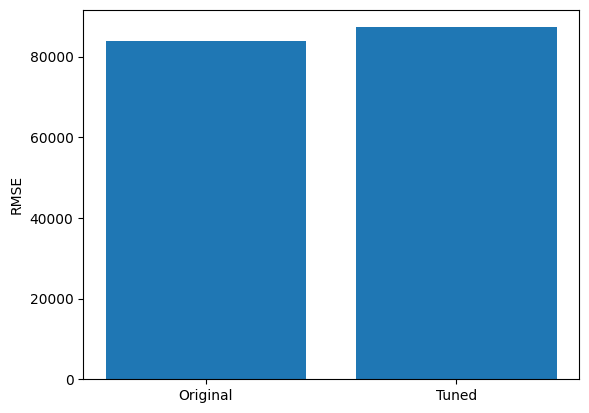

In [33]:
plt.bar(['Original', 'Tuned'], [rmse_orig, rmse_tuned])
plt.ylabel('RMSE')
plt.show()

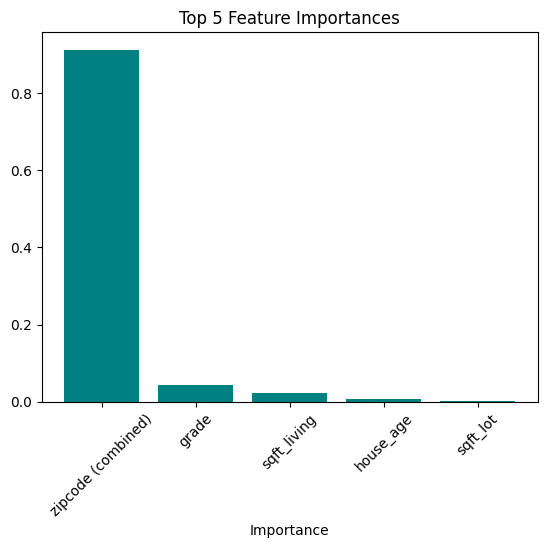

In [36]:

import pandas as pd
import matplotlib.pyplot as plt

importances = best_model.named_steps['regressor'].feature_importances_

encoded_cat = preprocessor.named_transformers_['category'].named_steps['onehot']
encoded_cat_names = encoded_cat.get_feature_names_out(categorical_features).tolist()
all_feature_names = numerical_features + encoded_cat_names + passthrough_features

feat_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})

zipcode_rows = feat_df[feat_df['Feature'].str.startswith('zipcode_')]
zipcode_total = zipcode_rows['Importance'].sum()

filtered_df = feat_df[~feat_df['Feature'].str.startswith('zipcode_')].copy()
filtered_df.loc[len(filtered_df)] = ['zipcode (combined)', zipcode_total]

top5 = filtered_df.sort_values(by='Importance', ascending=False).head(5)
plt.bar(top5['Feature'], top5['Importance'], color='teal')
plt.title('Top 5 Feature Importances')
plt.xlabel('Importance')
plt.xticks(rotation=45)
plt.show()

Summary of Top 5 Feature Importances

The feature zipcode (combined) has the highest importance in the model, indicating that location is the most influential factor in predicting house prices. This is followed by grade, which reflects the overall quality and design of the house. The next most important features are sqft_living, house_age, and sqft_lot, each contributing marginally to the model's predictions.

Among these, house_age is the only engineered feature, suggesting that feature engineering added meaningful value to the model. Overall, the distribution of importance aligns with common expectations in real estate, where location and structural quality typically dominate price estimation.